In [22]:
import pandas as pd

# TODO: update for state
STATE = 'ny'
YEARS = [str(yr) for yr in range(2013, 2021)]

In [28]:
"""
File naming convension for ACS 5-year downloads:
state_year_[race|income].csv

"""

def get_filepath(state):
    return '../data/{state}/'.format(state=state)

def get_fname(state, year, dataset_type):
    return '{state}_{year}_{dataset_type}.csv'.format(
        state=state, year=year, dataset_type=dataset_type)

def get_filename(state, year, dataset_type):
    return get_filepath(state) + get_fname(state, year, dataset_type)


# geoid is the column we join data on
geoid_column_name = 'geoid'

geoid_column_map = {
    'GEO.id2': geoid_column_name,
    'GEO_ID': geoid_column_name
}

# for some reason particular file(s) have different column names- WHY?!
filename_income_column_map = {
    'ma_2017_income.csv': {
        'HC03_EST_VC02': 'median income',
        'HC03_MOE_VC02': 'median income margin of error',
        'HD01_VD01': 'median income',
        'HD02_VD01': 'median income margin of error'
    }
}
# Here is the default
income_column_map = {
    'HC02_EST_VC02': 'median income',
    'HC02_MOE_VC02': 'median income margin of error',
    'HD01_VD01': 'median income',
    'HD02_VD01': 'median income margin of error'
}

new_income_map = {
    'S1903_C03_001E': 'median income',
    'S1903_C03_001M': 'median income margin of error'
}

race_column_map = {
    'HD01_VD01': 'race: total households',
    'HD02_VD01': 'race: total households margin of error',
    'HD01_VD02': 'race: White',
    'HD01_VD03': 'race: Black',
    'HD01_VD05': 'race: Asian',
    'HD01_VD08': 'race: 2 or more races',
    # The following are combined into one value
    # 'HD01_VD04': 'race: American Indian and Alaska',
    # 'HD01_VD06': 'race: Native Hawaiian and Other',
    'HD01_VD07': 'race: Other',
}

new_race_column_map = {
    'B02001_001E': 'race: total households',
    'B02001_001M': 'race: total households margin of error',
    'B02001_002E': 'race: White',
    'B02001_003E': 'race: Black',
    'B02001_005E': 'race: Asian',
    'B02001_008E': 'race: 2 or more races',
    'B02001_007E': 'race: Other'
}

def race_combine_other(row):
    
    """Combines the values for the other races with american indian, hawaiian, etc"""
    try:
        return int(row['HD01_VD04']) + int(row['HD01_VD06']) + int(row['HD01_VD07'])
    except:
        return int(row['B02001_004E']) + int(row['B02001_006E']) + int(row['B02001_007E'])

def col_name_for_year(year, col_name):
    return str(year) + ' ' + col_name

def remove_labels(df):
    # drop the first row (the first row is a display label)
    df.drop([0], inplace=True)

def preprocess_df(df, year, column_map):
    # prune data
    #data from 2018-onwards only has GEO_ID not GEO.id2
    if int(year) >= 2017:
        for num in range(1, df.shape[0]+1):
            df.at[num, 'GEO_ID'] = df.at[num, 'GEO_ID'][-11:]
        
    # rename columns
    column_name_map = {key: col_name_for_year(year, value) for key, value in column_map.items()}
    
    column_name_map.update(geoid_column_map)
    cols_to_drop = [col for col in df.columns if not col in column_name_map.keys()]

    df.drop(cols_to_drop,  axis=1,  inplace=True)
    df.rename(columns=column_name_map, inplace=True)
    df.set_index(geoid_column_name, inplace=True)
    return df


def get_race_df(state, year):
    filename = get_filename(STATE, year, 'race')
    df = pd.read_csv(filename)
    remove_labels(df)
    # if int(year) < 2018:
    #     column = 'HD01_VD07'
    # else:
    #     column = 'B02001_007E'
    df['column'] = df.apply(race_combine_other, axis=1)
    if int(year) >= 2017:
        map = new_race_column_map
    else:
        map = race_column_map
    return preprocess_df(df, year, map)


def get_income_df(state, year):
    # so annoying that the columns change with files!
    if int(year) >= 2017:
        map = new_income_map
    else:
        map = income_column_map
    fname = get_fname(state, year, 'income')
    print('filename', fname)
    if fname in filename_income_column_map:
        map = filename_income_column_map[fname]
    df = pd.read_csv(get_filename(STATE, year, 'income'))
    remove_labels(df)
    return preprocess_df(df, year, map)


In [29]:
# We merge data into the income df

def add_df(df1, df2):
    # comebine the df's on geoid
    return pd.concat([df1, df2], axis=1, join='inner')

state_df = None
for year in YEARS:
    print('handling files for year ', year)
    income_df = get_income_df(STATE, year)
    if state_df is None:
        state_df = income_df
    else:
        state_df = add_df(state_df, income_df)
    print(state_df)
    race_df = get_race_df(STATE, year)
    state_df = add_df(state_df, race_df)

state_df.head()

handling files for year  2013
filename ny_2013_income.csv
            2013 median income 2013 median income margin of error
geoid                                                            
36001000100              35900                              11519
36001000200              20665                               4142
36001000300              35951                               8746
36001000401              71921                               6952
36001000403              50952                              13933
...                        ...                                ...
36123150100              51168                               5643
36123150200              45281                               5108
36123150300              49139                               3542
36123150400              50135                               6619
36123150500              52452                               5594

[4918 rows x 2 columns]
handling files for year  2014
filename ny_2014_income.csv
 

C:\Users\Walter\AppData\Local\Temp\ipykernel_29432\2226537776.py:131: DtypeWarning: Columns (2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,110,111,148,149) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(get_filename(STATE, year, 'income'))


            2013 median income 2013 median income margin of error  \
geoid                                                               
36001000100              35900                              11519   
36001000200              20665                               4142   
36001000300              35951                               8746   
36001000401              71921                               6952   
36001000403              50952                              13933   
...                        ...                                ...   
36123150100              51168                               5643   
36123150200              45281                               5108   
36123150300              49139                               3542   
36123150400              50135                               6619   
36123150500              52452                               5594   

            2013 race: total households  \
geoid                                     
36001000100     

C:\Users\Walter\AppData\Local\Temp\ipykernel_29432\2226537776.py:131: DtypeWarning: Columns (2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,110,111,148,149) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(get_filename(STATE, year, 'income'))


            2013 median income 2013 median income margin of error  \
geoid                                                               
36001000100              35900                              11519   
36001000200              20665                               4142   
36001000300              35951                               8746   
36001000401              71921                               6952   
36001000403              50952                              13933   
...                        ...                                ...   
36123150100              51168                               5643   
36123150200              45281                               5108   
36123150300              49139                               3542   
36123150400              50135                               6619   
36123150500              52452                               5594   

            2013 race: total households  \
geoid                                     
36001000100     

C:\Users\Walter\AppData\Local\Temp\ipykernel_29432\2226537776.py:131: DtypeWarning: Columns (2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,110,111,148,149) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(get_filename(STATE, year, 'income'))


            2013 median income 2013 median income margin of error  \
geoid                                                               
36001000100              35900                              11519   
36001000200              20665                               4142   
36001000300              35951                               8746   
36001000401              71921                               6952   
36001000403              50952                              13933   
...                        ...                                ...   
36123150100              51168                               5643   
36123150200              45281                               5108   
36123150300              49139                               3542   
36123150400              50135                               6619   
36123150500              52452                               5594   

            2013 race: total households  \
geoid                                     
36001000100     

C:\Users\Walter\AppData\Local\Temp\ipykernel_29432\2226537776.py:131: DtypeWarning: Columns (2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,110,111,148,149) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(get_filename(STATE, year, 'income'))


            2013 median income 2013 median income margin of error  \
geoid                                                               
36001000100              35900                              11519   
36001000401              71921                               6952   
36001000403              50952                              13933   
36001000404                  -                                 **   
36001000501              26711                               5597   
...                        ...                                ...   
36121970900              53523                               9888   
36121971000              45280                               4273   
36121971100              46000                               4133   
36123150200              45281                               5108   
36123150400              50135                               6619   

            2013 race: total households  \
geoid                                     
36001000100     

,2013 median income,2013 median income margin of error,2013 race: total households,2013 race: total households margin of error,2013 race: White,2013 race: Black,2013 race: Asian,2013 race: Other,2013 race: 2 or more races,2014 median income,...,2019 race: 2 or more races,2020 median income,2020 median income margin of error,2020 race: total households,2020 race: total households margin of error,2020 race: White,2020 race: Black,2020 race: Asian,2020 race: Other,2020 race: 2 or more races
geoid,,,,,,,,,,,,,,,,,,,,,
36001000100,35900,11519,2163,287,597,1363,41,83,79,30750,...,174,45268,9014,2029,355,481,1141,99,62,218
36001000401,71921,6952,2380,200,2113,173,51,0,35,71343,...,20,76500,17580,2336,395,2017,234,13,12,60
36001000403,50952,13933,4338,522,2893,857,486,68,34,52740,...,144,77193,13665,4014,669,2869,458,342,106,239
36001000404,-,**,4932,492,3550,686,330,155,187,-,...,192,-,**,5045,431,3107,1035,333,299,268
36001000501,26711,5597,3612,469,2164,799,149,31,457,29115,...,246,29579,10766,3410,720,1603,1229,142,80,325


In [39]:
# Save the giant dataframe to CSV
output_csvfilename = get_filepath(STATE) + 'race_and_income_data.csv'
state_df.to_csv(output_csvfilename)
print('saved data to ',  output_csvfilename)

saved data to  ../data/ny/race_and_income_data.csv


In [40]:
import geopandas as gpd

In [41]:
"""Creates shapefile from NYC open data download.
This shapefile does not have geoids, so must add them based on its other data.

"""

NY_STATE_CODE = '36'

nyc_shapefile_attributes = {
    geoid_column_name: geoid_column_name,
    'ntaname': 'Name', # name of neighborhood in this dataset
    # Tracts are duplicated across boros.
    # The unique key is 'boro_ct201' which is the concatenation of boro id and ct
    # 'ct2010': 'tract',
    'shape_area': 'shape_area',
    'shape_leng': 'shape_leng',
    'geometry': 'geometry'
}
ma_shapefile_attributes = {
    'GEOID10': geoid_column_name,
    'NAMELSAD10': 'Name', # 'Census Tract ###'  in this dataset
    'SHAPE_AREA': 'shape_area',
    'SHAPE_LEN': 'shape_leng',
    'geometry': 'geometry'
}

# Mapping of boro names to county code for geoid
# Taken from wikipedia info: https://en.wikipedia.org/wiki/List_of_counties_in_New_York
nyc_boro_to_county_code = {
    'Bronx':'005',
    'Queens':'081',
    'Brooklyn':'047',
    'Manhattan':'061',
    'Staten Island':'085'
}


def get_nyc_shapefile():
    shapefile_filename = get_filepath('ny') + 'city_census_tracts_shapefile/geo_export_6f3df1e4-1be2-4395-ba6c-3e15b0a10221.shp'
    shapefile_df = gpd.read_file(shapefile_filename)
    shapefile_df[geoid_column_name] = shapefile_df.apply(get_nyc_geoid, axis=1)
    return shapefile_df


def get_nyc_county_code(row):
    boro_name = row['boro_name']
    return nyc_boro_to_county_code[boro_name]


def get_nyc_geoid(row):
    state_code = NY_STATE_CODE
    county_code = get_nyc_county_code(row)
    tract_code = row['ct2010']
    return str(state_code) + str(county_code) + str(tract_code)

shapefile_df = None
if STATE == 'ny':
    shapefile_df = get_nyc_shapefile()
    shapefile_attributes = nyc_shapefile_attributes
elif STATE == 'ma':
    shapefile_filename = get_filepath(STATE) + 'shapefile/boston-brookline-cambridge-somerville-everett.shp'
    shapefile_df = gpd.read_file(shapefile_filename)
    shapefile_attributes = ma_shapefile_attributes

shapefile_df.head()

,boro_code,boro_ct201,boro_name,cdeligibil,ct2010,ctlabel,ntacode,ntaname,puma,shape_area,shape_leng,geometry,geoid
0,5,5000900,Staten Island,E,000900,9,SI22,West New Brighton-New Brighton-St. George,3903,2.497010e+06,7729.016794,"POLYGON ((-74.07921 40.64343, -74.07914 40.643...",36085000900
1,1,1009800,Manhattan,I,009800,98,MN19,Turtle Bay-East Midtown,3808,1.906016e+06,5534.199811,"POLYGON ((-73.96433 40.75638, -73.96479 40.755...",36061009800
2,1,1010000,Manhattan,I,010000,100,MN19,Turtle Bay-East Midtown,3808,1.860938e+06,5692.168737,"POLYGON ((-73.96802 40.75958, -73.96848 40.758...",36061010000
3,1,1010200,Manhattan,I,010200,102,MN17,Midtown-Midtown South,3807,1.860993e+06,5687.802439,"POLYGON ((-73.97124 40.76094, -73.97170 40.760...",36061010200
4,1,1010400,Manhattan,I,010400,104,MN17,Midtown-Midtown South,3807,1.864600e+06,5693.036367,"POLYGON ((-73.97446 40.76229, -73.97491 40.761...",36061010400


In [42]:
# Map column names and remove columns
shapefile_cols_to_drop = [col for col in shapefile_df.columns if not col in shapefile_attributes.keys()]
shapefile_df.drop(shapefile_cols_to_drop,  axis=1,  inplace=True)
shapefile_df.rename(columns=shapefile_attributes, inplace=True)
shapefile_df.set_index(geoid_column_name, inplace=True)
shapefile_df.head()

,Name,shape_area,shape_leng,geometry
geoid,,,,
36085000900,West New Brighton-New Brighton-St. George,2.497010e+06,7729.016794,"POLYGON ((-74.07921 40.64343, -74.07914 40.643..."
36061009800,Turtle Bay-East Midtown,1.906016e+06,5534.199811,"POLYGON ((-73.96433 40.75638, -73.96479 40.755..."
36061010000,Turtle Bay-East Midtown,1.860938e+06,5692.168737,"POLYGON ((-73.96802 40.75958, -73.96848 40.758..."
36061010200,Midtown-Midtown South,1.860993e+06,5687.802439,"POLYGON ((-73.97124 40.76094, -73.97170 40.760..."
36061010400,Midtown-Midtown South,1.864600e+06,5693.036367,"POLYGON ((-73.97446 40.76229, -73.97491 40.761..."


c:\Users\Walter\anaconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


<AxesSubplot:>

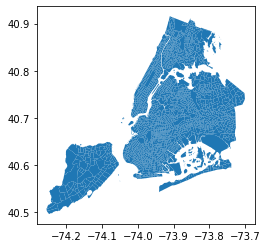

In [43]:
# Want projection CRS84 which is equivalent to EPSG:4326
shapefile_df = shapefile_df.to_crs({'init': 'epsg:4326'})

%matplotlib inline
shapefile_df.plot()

In [44]:
merged_shapes = shapefile_df.merge(state_df, on=geoid_column_name)
print('shape', merged_shapes.shape)
merged_shapes.head()

shape (2034, 76)


,Name,shape_area,shape_leng,geometry,2013 median income,2013 median income margin of error,2013 race: total households,2013 race: total households margin of error,2013 race: White,2013 race: Black,...,2019 race: 2 or more races,2020 median income,2020 median income margin of error,2020 race: total households,2020 race: total households margin of error,2020 race: White,2020 race: Black,2020 race: Asian,2020 race: Other,2020 race: 2 or more races
geoid,,,,,,,,,,,,,,,,,,,,,
36085000900,West New Brighton-New Brighton-St. George,2.497010e+06,7729.016794,"POLYGON ((-74.07921 40.64343, -74.07914 40.643...",60817,21649,2057,288,685,930,...,149,54821,20668,1875,392,937,667,107,57,107
36061009800,Turtle Bay-East Midtown,1.906016e+06,5534.199811,"POLYGON ((-73.96433 40.75638, -73.96479 40.755...",104198,11773,7105,642,5876,134,...,175,106392,17609,7099,1170,5657,174,1050,46,146
36061010000,Turtle Bay-East Midtown,1.860938e+06,5692.168737,"POLYGON ((-73.96802 40.75958, -73.96848 40.758...",86156,14020,1829,233,1251,49,...,31,80691,51042,1735,414,1228,49,329,66,63
36061010200,Midtown-Midtown South,1.860993e+06,5687.802439,"POLYGON ((-73.97124 40.76094, -73.97170 40.760...",160729,140285,313,102,298,8,...,10,80951,29826,160,111,138,7,1,0,14
36061010400,Midtown-Midtown South,1.864600e+06,5693.036367,"POLYGON ((-73.97446 40.76229, -73.97491 40.761...",98438,45233,1031,158,815,11,...,10,127845,30178,842,189,568,12,203,40,7


In [45]:
from shapely.geometry.polygon import Polygon
from shapely.geometry.multipolygon import MultiPolygon

In [46]:
to_filename = get_filepath(STATE) + STATE  + '_census_tracts.geojson'
print('saving to ',to_filename)
merged_shapes["geometry"] = [MultiPolygon([feature]) if type(feature) == Polygon \
    else feature for feature in merged_shapes["geometry"]]
merged_shapes.to_file(to_filename, driver='GeoJSON')
print('saved')
sort = False

saving to  ../data/ny/ny_census_tracts.geojson
saved
